In [ ]:
import numpy as np
import pandas as pd
import datetime
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data import TimeFrame
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import plotly.graph_objects as go
from plotly.subplots import make_subplots

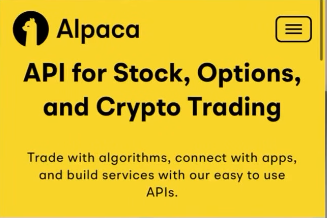

In [ ]:
#scrape data -> Alpaca

True

In [ ]:
def adjust_for_stock_split(df, split_date, split_ratio):
    """
    Adjust historical data for stock splits

    Args:
        df: DataFrame with OHLCV data
        split_date: Date of the stock split (YYYY-MM-DD format)
        split_ratio: Split ratio (e.g., 10 for a 10:1 split)
    """

    df_adjusted = df.copy()

    if isinstance(split_date, str):
        split_date = pd.to_datetime(split_date).tz_localize('UTC')

    pre_split_mask = df_adjusted.index < split_date

    if pre_split_mask.any():
        print(f"Adjusting {pre_split_mask.sum()} data points for {split_ratio}:1 stock split on {split_date.date()}")

        price_columns = ['open', 'high', 'low', 'close']
        for col in price_columns:
            if col in df_adjusted.columns:
                df_adjusted.loc[pre_split_mask, col] = df_adjusted.loc[pre_split_mask, col] / split_ratio

        if 'volume' in df_adjusted.columns:
            df_adjusted.loc[pre_split_mask, 'volume'] = df_adjusted.loc[pre_split_mask, 'volume'] * split_ratio

    return df_adjusted

In [ ]:
#Featues

def prepare_data(df, look_back=10):
    features = ['close', 'SMA5', 'SMA20', 'SMA50', 'Price_Change', 'RSI', 'MACD', 'MACD_Signal']
    df_clean = df.dropna()

In [ ]:
#LSTM-CNN -> for time series data

def create_model(input_shape):
    from tensorflow.keras.regularizers import L2

    model = Sequential([
        LSTM(32, input_shape=input_shape, return_sequences=True,
             recurrent_dropout=0.2, dropout=0.2,
             kernel_regularizer=l2(0.001)),
        LSTM(16, return_sequences=False,
             recurrent_dropout=0.2, dropout=0.2,
             kernel_regularizer=l2(0.001)),
        Dense(8, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# -----------------------------------------------------------------------------
# STEP 0: Setup and Imports
# This script is designed to run in a Google Colab environment.
# -----------------------------------------------------------------------------

# Install necessary libraries (Run this cell first in Colab)
# We need alpaca-py for data and pandas_ta for the technical indicators
!pip install alpaca-py pandas_ta -q

import numpy as np
import pandas as pd
import datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Alpaca Imports
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data import TimeFrame

# Sklearn Imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# TensorFlow/Keras Imports (Matching your first snippet)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [ ]:
# -----------------------------------------------------------------------------
# STEP 1: Configuration & API Setup
# You MUST replace these with your actual Alpaca credentials
# -----------------------------------------------------------------------------

# NOTE: For security, never hardcode keys in production. Use environment variables.
# In Colab, you can use: from google.colab import userdata; API_KEY = userdata.get('ALPACA_KEY')
API_KEY = "YOUR_ALPACA_API_KEY"
SECRET_KEY = "YOUR_ALPACA_SECRET_KEY"
STOCK_TICKER = "NVDA"

# Fetching data from 2020 to ensure we have enough history for the LSTM to learn trends
START_DATE = datetime.datetime(2020, 1, 1, tzinfo=datetime.timezone.utc)
END_DATE = datetime.datetime.now(datetime.timezone.utc)

LOOK_BACK = 10    # The number of previous days to look at (from your snippet)
SPLIT_RATIO = 0.8 # 80% for training


# Initialize Alpaca Client
stock_client = StockHistoricalDataClient(API_KEY, SECRET_KEY)


In [ ]:
# -----------------------------------------------------------------------------
# STEP 2: Data Fetching and Adjustments
# -----------------------------------------------------------------------------

def get_stock_data(symbol, start_date, end_date):
    """Fetches daily stock data from Alpaca."""
    print(f"Fetching data for {symbol}...")
    request_params = StockBarsRequest(
        symbol_or_symbols=[symbol],
        timeframe=TimeFrame.Day,
        start=start_date,
        end=end_date
    )
    bars = stock_client.get_stock_bars(request_params)
    df = bars.df
    # Extract only the data for the specified symbol, sort index and clean up
    df = df.loc[symbol].sort_index()
    return df[['open', 'high', 'low', 'close', 'volume']]

def adjust_for_stock_split(df, split_date, split_ratio):
    """
    Adjust historical data for stock splits.
    (Matches your second snippet exactly)
    """
    df_adjusted = df.copy()

    if isinstance(split_date, str):
        split_date = pd.to_datetime(split_date).tz_localize('UTC')

    pre_split_mask = df_adjusted.index < split_date

    if pre_split_mask.any():
        print(f"Adjusting {pre_split_mask.sum()} data points for {split_ratio}:1 stock split on {split_date.date()}")

        price_columns = ['open', 'high', 'low', 'close']
        for col in price_columns:
            if col in df_adjusted.columns:
                df_adjusted.loc[pre_split_mask, col] = df_adjusted.loc[pre_split_mask, col] / split_ratio

        if 'volume' in df_adjusted.columns:
            df_adjusted.loc[pre_split_mask, 'volume'] = df_adjusted.loc[pre_split_mask, 'volume'] * split_ratio

    return df_adjusted

def calculate_ta_features(df):
    """
    Calculates the technical analysis features required by the prepare_data function.
    Uses pandas_ta to generate SMA, RSI, and MACD.
    """
    import pandas_ta as ta

    df = df.copy()

    # Simple Moving Averages (SMA5, SMA20, SMA50)
    df.ta.sma(length=5, append=True)
    df.ta.sma(length=20, append=True)
    df.ta.sma(length=50, append=True)

    # Relative Strength Index (RSI)
    df.ta.rsi(append=True)

    # MACD (Moving Average Convergence Divergence)
    # The default call adds MACD, MACDH, and MACDS (Signal)
    df.ta.macd(append=True)

    # Price Change
    df['Price_Change'] = df['close'].pct_change() * 100

    # Rename columns to match your 'prepare_data' features list EXACTLY
    df.rename(columns={
        'RSI_14': 'RSI',
        'MACD_12_26_9': 'MACD',
        'MACDs_12_26_9': 'MACD_Signal',
        'SMA_5': 'SMA5',
        'SMA_20': 'SMA20',
        'SMA_50': 'SMA50',
    }, inplace=True)

    return df

In [ ]:
# -----------------------------------------------------------------------------
# STEP 3: Data Preparation for LSTM
# -----------------------------------------------------------------------------

def prepare_data(df, look_back=10):
    """
    Prepares features (X) and target (Y) arrays for the LSTM model.
    (Matches your third snippet)
    """
    # Features list from your snippet
    features_list = ['close', 'SMA5', 'SMA20', 'SMA50', 'Price_Change', 'RSI', 'MACD', 'MACD_Signal']

    # 1. Create the Target Variable (Y): 1 if price goes up tomorrow, 0 otherwise
    # We predict the direction of the *next* day
    df['Next_Close'] = df['close'].shift(-1)
    df['Target'] = (df['Next_Close'] > df['close']).astype(int)

    # 2. Clean the data (drop NaNs from indicators and the shifted target)
    df_clean = df.dropna()
    print(f"Data cleaned. {len(df_clean)} rows remaining.")

    # Select only the features we need
    data = df_clean[features_list].values
    target = df_clean['Target'].values

    # 3. Normalize the data (Crucial for LSTM performance)
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    # 4. Create Sequences (X) and corresponding Targets (Y)
    X, Y = [], []
    for i in range(look_back, len(scaled_data) - 1):
        # We take the previous 'look_back' days to predict the target at 'i'
        X.append(scaled_data[i-look_back:i, :])
        Y.append(target[i])

    X = np.array(X)
    Y = np.array(Y)

    # 5. Split Data into Train and Test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=(1 - SPLIT_RATIO), shuffle=False # Important: Don't shuffle time-series data!
    )

    print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

    return X_train, X_test, y_train, y_test, scaler

In [ ]:
# -----------------------------------------------------------------------------
# STEP 4: Model Definition and Training
# -----------------------------------------------------------------------------

def create_model(input_shape):
    """
    Defines the LSTM model architecture.
    (Matches your fourth snippet exactly)
    """
    model = Sequential([
        LSTM(32, input_shape=input_shape, return_sequences=True,
             recurrent_dropout=0.2, dropout=0.2,
             kernel_regularizer=l2(0.001)),
        LSTM(16, return_sequences=False,
             recurrent_dropout=0.2, dropout=0.2,
             kernel_regularizer=l2(0.001)),
        Dense(8, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        Dense(1, activation='sigmoid') # Sigmoid is perfect for binary output (0 or 1)
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# -----------------------------------------------------------------------------
# STEP 5: Main Execution Pipeline
# -----------------------------------------------------------------------------

def run_prediction_pipeline():
    """Main function to execute the entire pipeline."""
    try:
        # Check if keys are set
        if API_KEY == "YOUR_ALPACA_API_KEY":
            print("⚠️ PLEASE ENTER YOUR ALPACA API KEYS IN STEP 1 ⚠️")
            return

        print("--- Starting Pipeline ---")

        # 1. Fetch Data
        df = get_stock_data(STOCK_TICKER, START_DATE, END_DATE)

        # 2. Adjust for Splits (Optional: Manually add split logic here if needed)
        # For NVDA, there was a 10:1 split on 2024-06-10.
        # The API might already adjust this, but if not, use:
        # df = adjust_for_stock_split(df, '2024-06-10', 10)

        # 3. Calculate Features
        print("Calculating Technical Indicators...")
        df_with_ta = calculate_ta_features(df)

        # 4. Prepare Data for LSTM
        print("Preparing Data...")
        X_train, X_test, y_train, y_test, scaler = prepare_data(df_with_ta, LOOK_BACK)

        # Determine input shape for the model (timesteps, features)
        input_shape = (X_train.shape[1], X_train.shape[2])

        # 5. Create and Train Model
        model = create_model(input_shape)

        print("\n--- Training Model ---")
        history = model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=32,
            validation_data=(X_test, y_test),
            verbose=1
        )

        # 6. Evaluate
        loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
        print(f"\n--- Results ---")
        print(f"Test Accuracy: {accuracy*100:.2f}%")

        # 7. Visualization
        # Plotting the Training History
        fig_history = make_subplots(rows=1, cols=2, subplot_titles=("Model Loss", "Model Accuracy"))
        fig_history.add_trace(go.Scatter(y=history.history['loss'], name='Train Loss'), row=1, col=1)
        fig_history.add_trace(go.Scatter(y=history.history['val_loss'], name='Val Loss'), row=1, col=1)
        fig_history.add_trace(go.Scatter(y=history.history['accuracy'], name='Train Acc'), row=1, col=2)
        fig_history.add_trace(go.Scatter(y=history.history['val_accuracy'], name='Val Acc'), row=1, col=2)
        fig_history.show()

    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == '__main__':
    run_prediction_pipeline()